# Mall Customer Segmentation Dataset

(https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

Table of Contents:

1. Data Analysis
    - Data Description
    - Data Loading and Cleanup
    - Exploratory Data Analysis (EDA)
        - Correlation Heatmap
        - Relationship between variables
        - Scatter-matrix
        - Distribution Plots
        - Box Plots
        - Count Plots
    - Data Preprocessing
2. Machine Learning
    - Model Selection
    - Hyperparameter tuning
3. Conclusions

## Data Analysis

### Data Description

This dataset purports to represent customer data collected by a shopping mall administration team. The dataset consists of 200 rows and 5 columns.

The 5 columns are:
- CustomerID (numeric)
- Gender (numeric)
- Age (numeric)
- Anuual income (k$)
- Spending score (1-100),

and each row represents a customer.

### Data Loading and Cleanup

In [2]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import seaborn as sns
sns.set_theme(style='ticks')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, skew, ttest_ind, f_oneway

from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

from sklearn.cluster import KMeans

In [3]:
#Create DataFrame object
df = pd.read_csv("Mall_Customers.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [6]:
#Checking for null-values
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [7]:
#Checking for duplicates
df.duplicated().sum()

0

In [8]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [9]:
#Reindexing
df.set_index('CustomerID', inplace=True); df

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [10]:
numerical_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [11]:
#Removing outliers outside of the 0.05-0.95 quantile range for all numerical categories
def remove_outliers_percentile(df, numerical_columns):
    for i,col in enumerate(df[numerical_columns]):
        min_threshold = df[col].quantile(0.05)
        max_threshold = df[col].quantile(0.95)
        df = df[(df[col] <= max_threshold) & (df[col] >= min_threshold)]
    return df

In [12]:
#Testing the outlier removal function
df_removed_outliers = remove_outliers_percentile(df,numerical_columns)
print(f'Shape of data before outlier removal: {df.shape}\nShape of data after outlier removal: {df_removed_outliers.shape}')

Shape of data before outlier removal: (200, 4)
Shape of data after outlier removal: (153, 4)


The outlier removal has been successful.

In [13]:
df = df_removed_outliers

### Exploratory Data Analysis

In [14]:
df[numerical_columns].corr()

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,0.030811,-0.388542
Annual Income (k$),0.030811,1.000000,-0.028389
Spending Score (1-100),-0.388542,-0.028389,1.000000


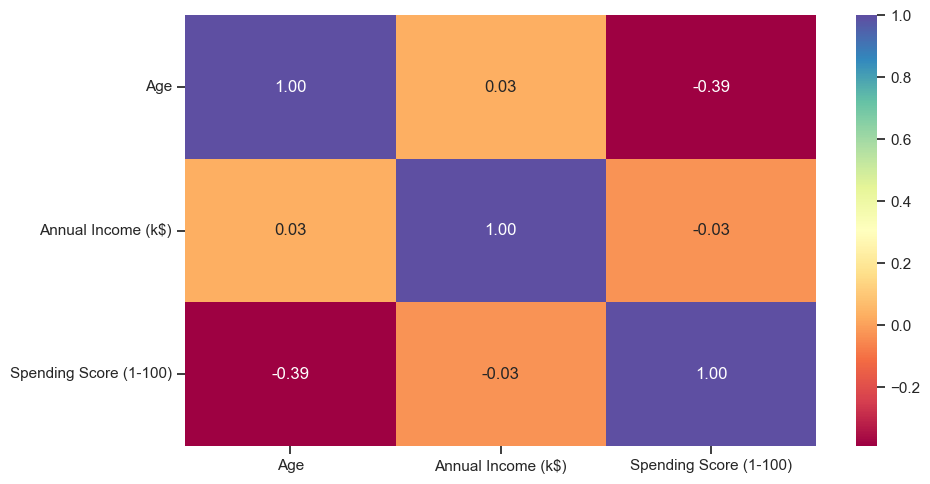

In [15]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(df[numerical_columns].corr(), cmap='Spectral', annot=True, fmt='.2f')
plt.tight_layout()
plt.savefig('images/01_Heatmap.png', bbox_inches='tight')
plt.show()

There is no significant correlation in the data. There is a weak negative correlation between a customer's Age and Spending Score with a Pearson's correlation coefficient of only -0.39.

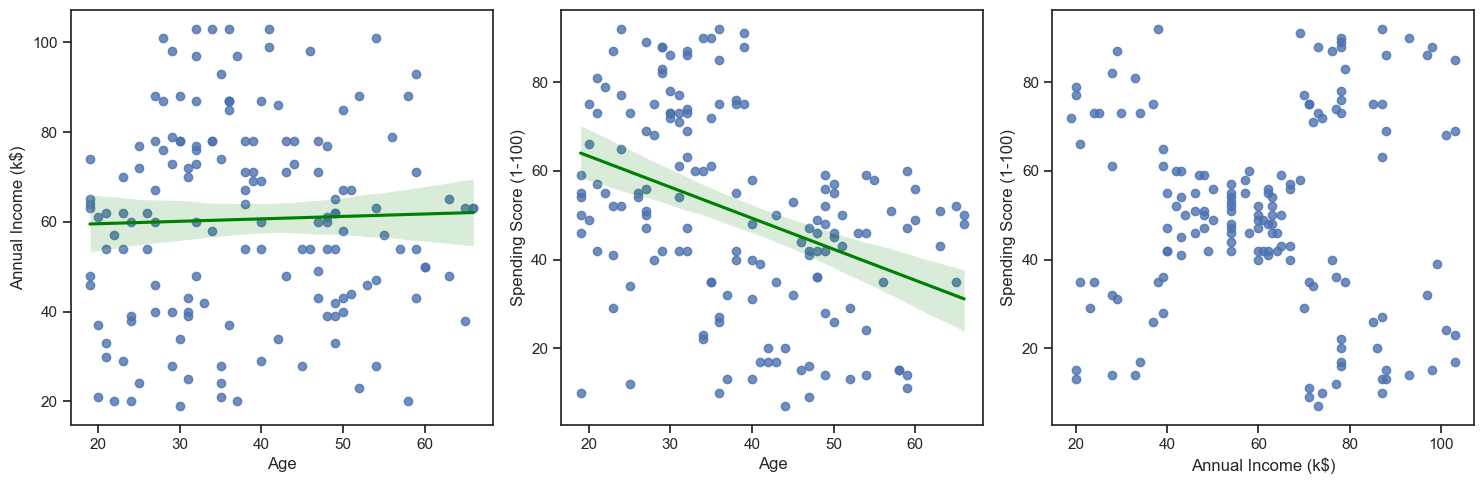

In [16]:
#Relational Plots
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)

sns.regplot(data=df, x='Age', y='Annual Income (k$)', ax=ax[0], fit_reg=True, line_kws={'color':'green'})
sns.regplot(data=df, x='Age', y='Spending Score (1-100)', ax=ax[1], fit_reg=True, line_kws={'color':'green'})
sns.regplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', ax=ax[2], fit_reg=False, line_kws={'color':'green'})
plt.tight_layout()
plt.savefig('images/01_Relational_plots.png', bbox_inches='tight')
plt.show()

The final relational plot is very interesting. It exhibits cluster patterns that divide customers into groups according their Annual Income and Spending Score. We see visible 5 clusters/segments of our customer base:
- People with relatively high annual income who spend a lot
- People with relatively high annual income who spend little
- People with relatively low annual income who spend a lot
- People with relatively low annual income who spend little
- People with average annual income who spend moderately

It would be more profitable for a Shopping Mall to sell products that are designed for only one of these customer groups (clusters) than to sell a product that would fall somewhere in between clusters in view of its price.

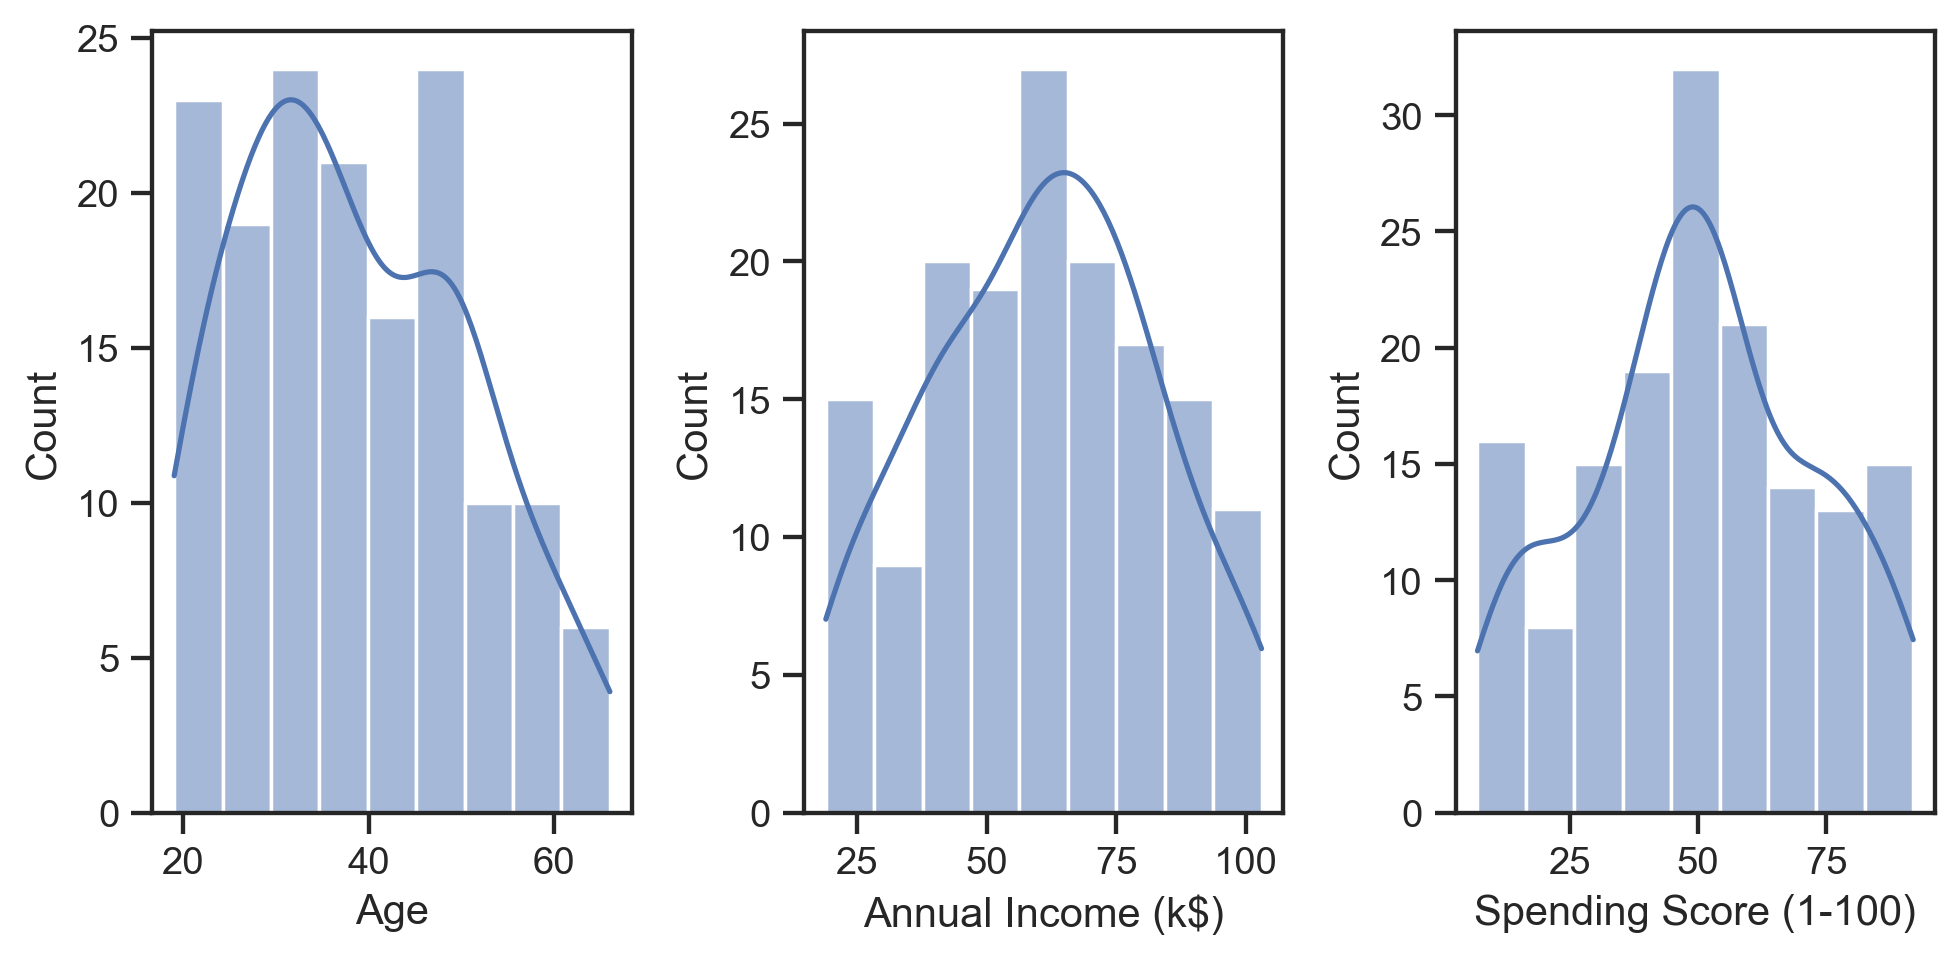

In [17]:
#Distribution plots
fig = plt.figure(figsize=(8,4), dpi=250)
for i,col in enumerate(numerical_columns):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=col, kde=True)
plt.tight_layout()
plt.savefig('images/01_Distributions.png', bbox_inches='tight')
plt.show()

The Age distribution plot is revealing a certain amount of skewness

In [20]:
df['Age'].skew()

0.32716854478297347

... which is still more than acceptable.

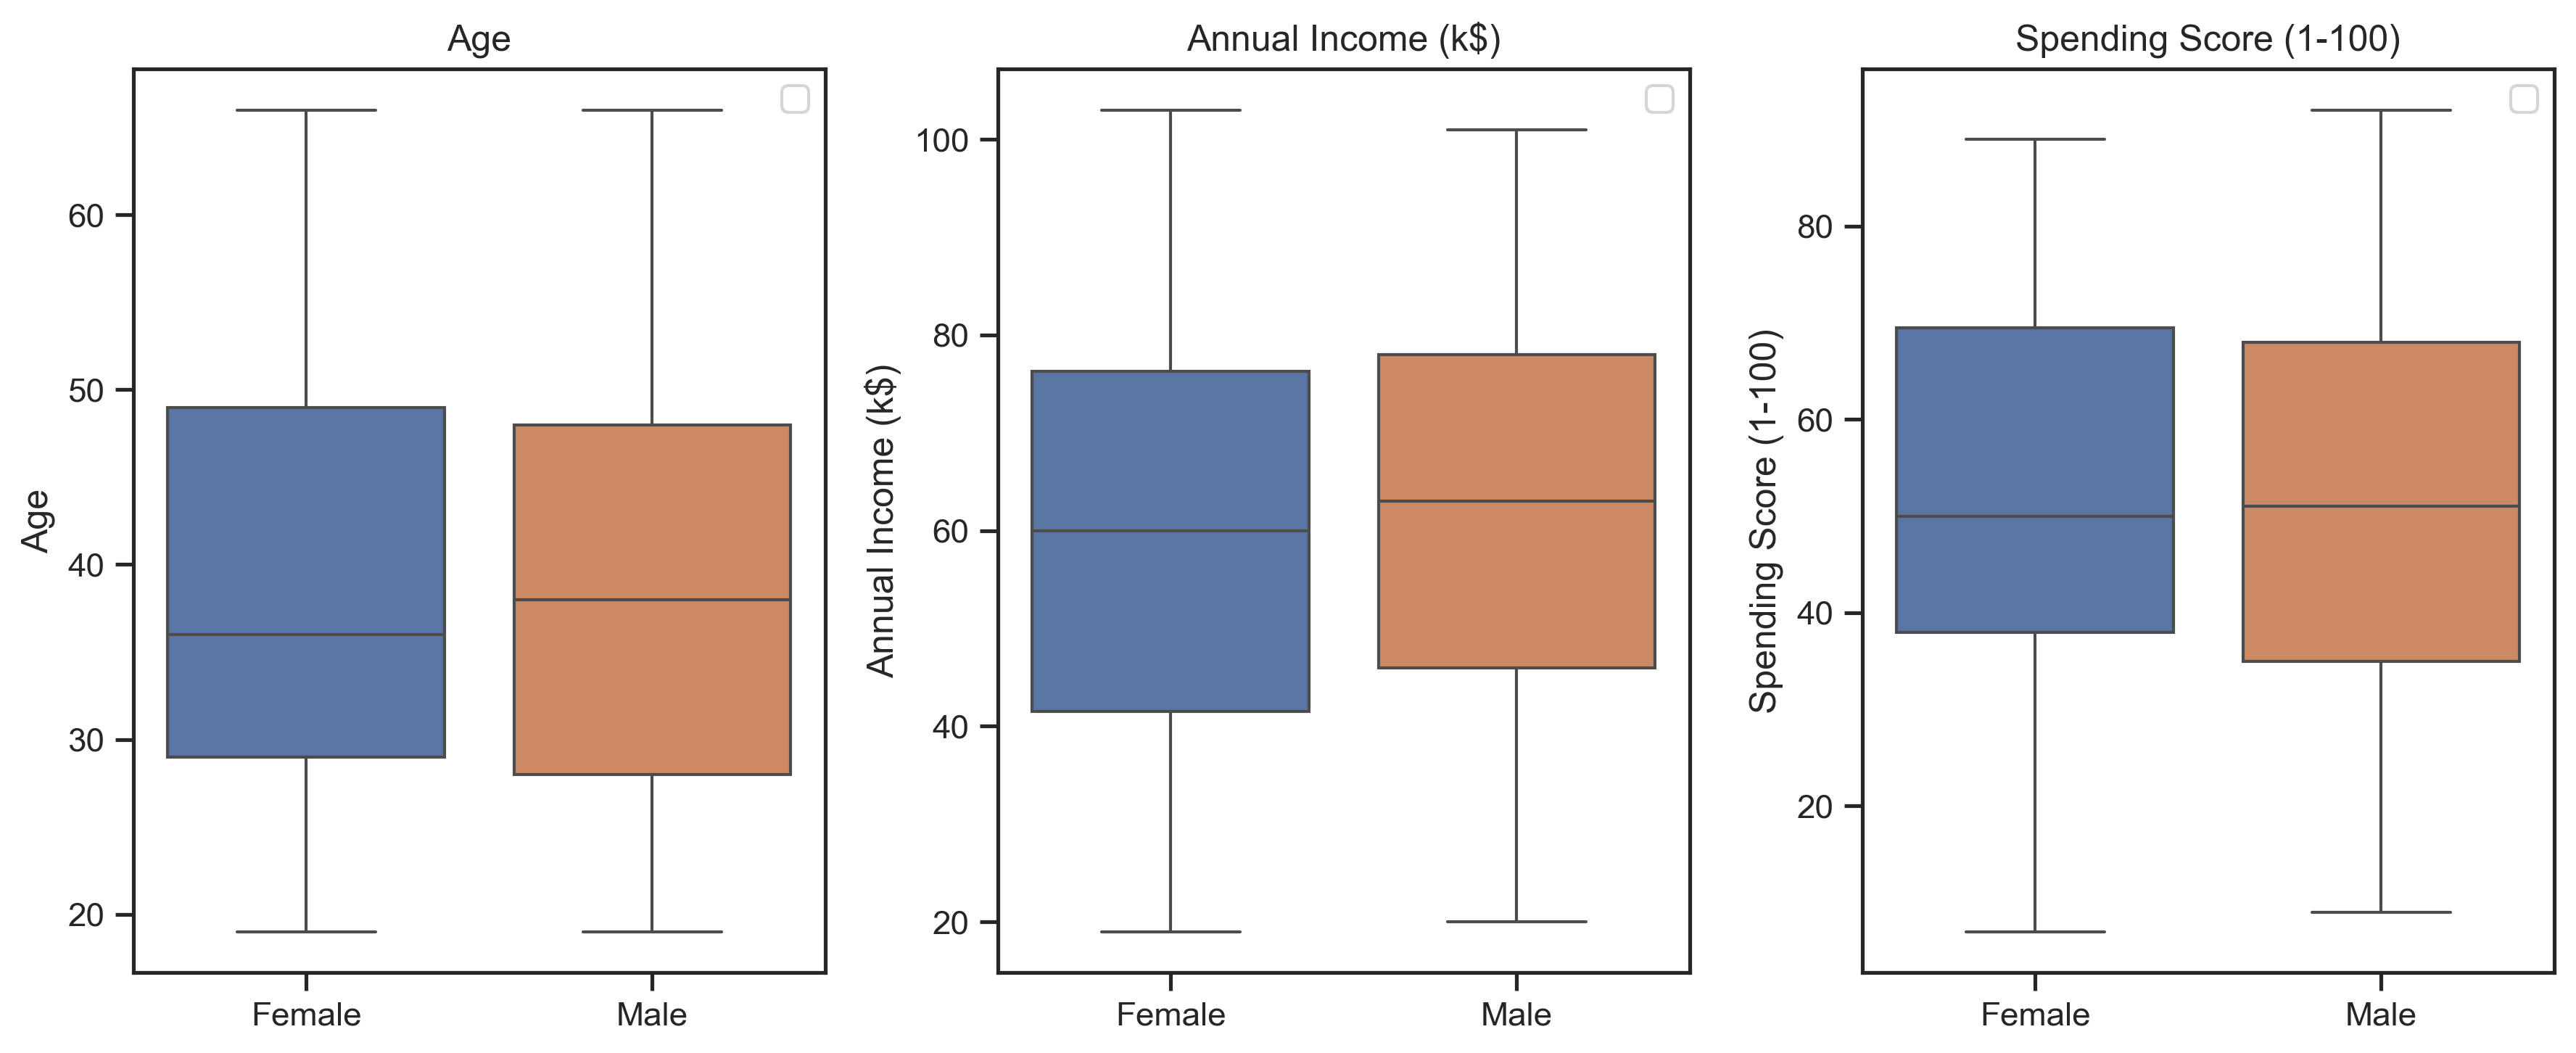

In [18]:
#Boxplots for numerical data
fig = plt.figure(figsize=(12,5), dpi=300)
for i, col in enumerate(numerical_columns):
    plt.subplot(1,3, i+1)
    sns.boxplot(x='Gender', y=col, data=df, hue='Gender')
    plt.legend('')
    plt.xlabel('')
    plt.ylabel(f'{col}')
    plt.title(f'{col}')

plt.tight_layout()
plt.savefig('images/01_Boxplots.png', bbox_inches='tight')
plt.show()

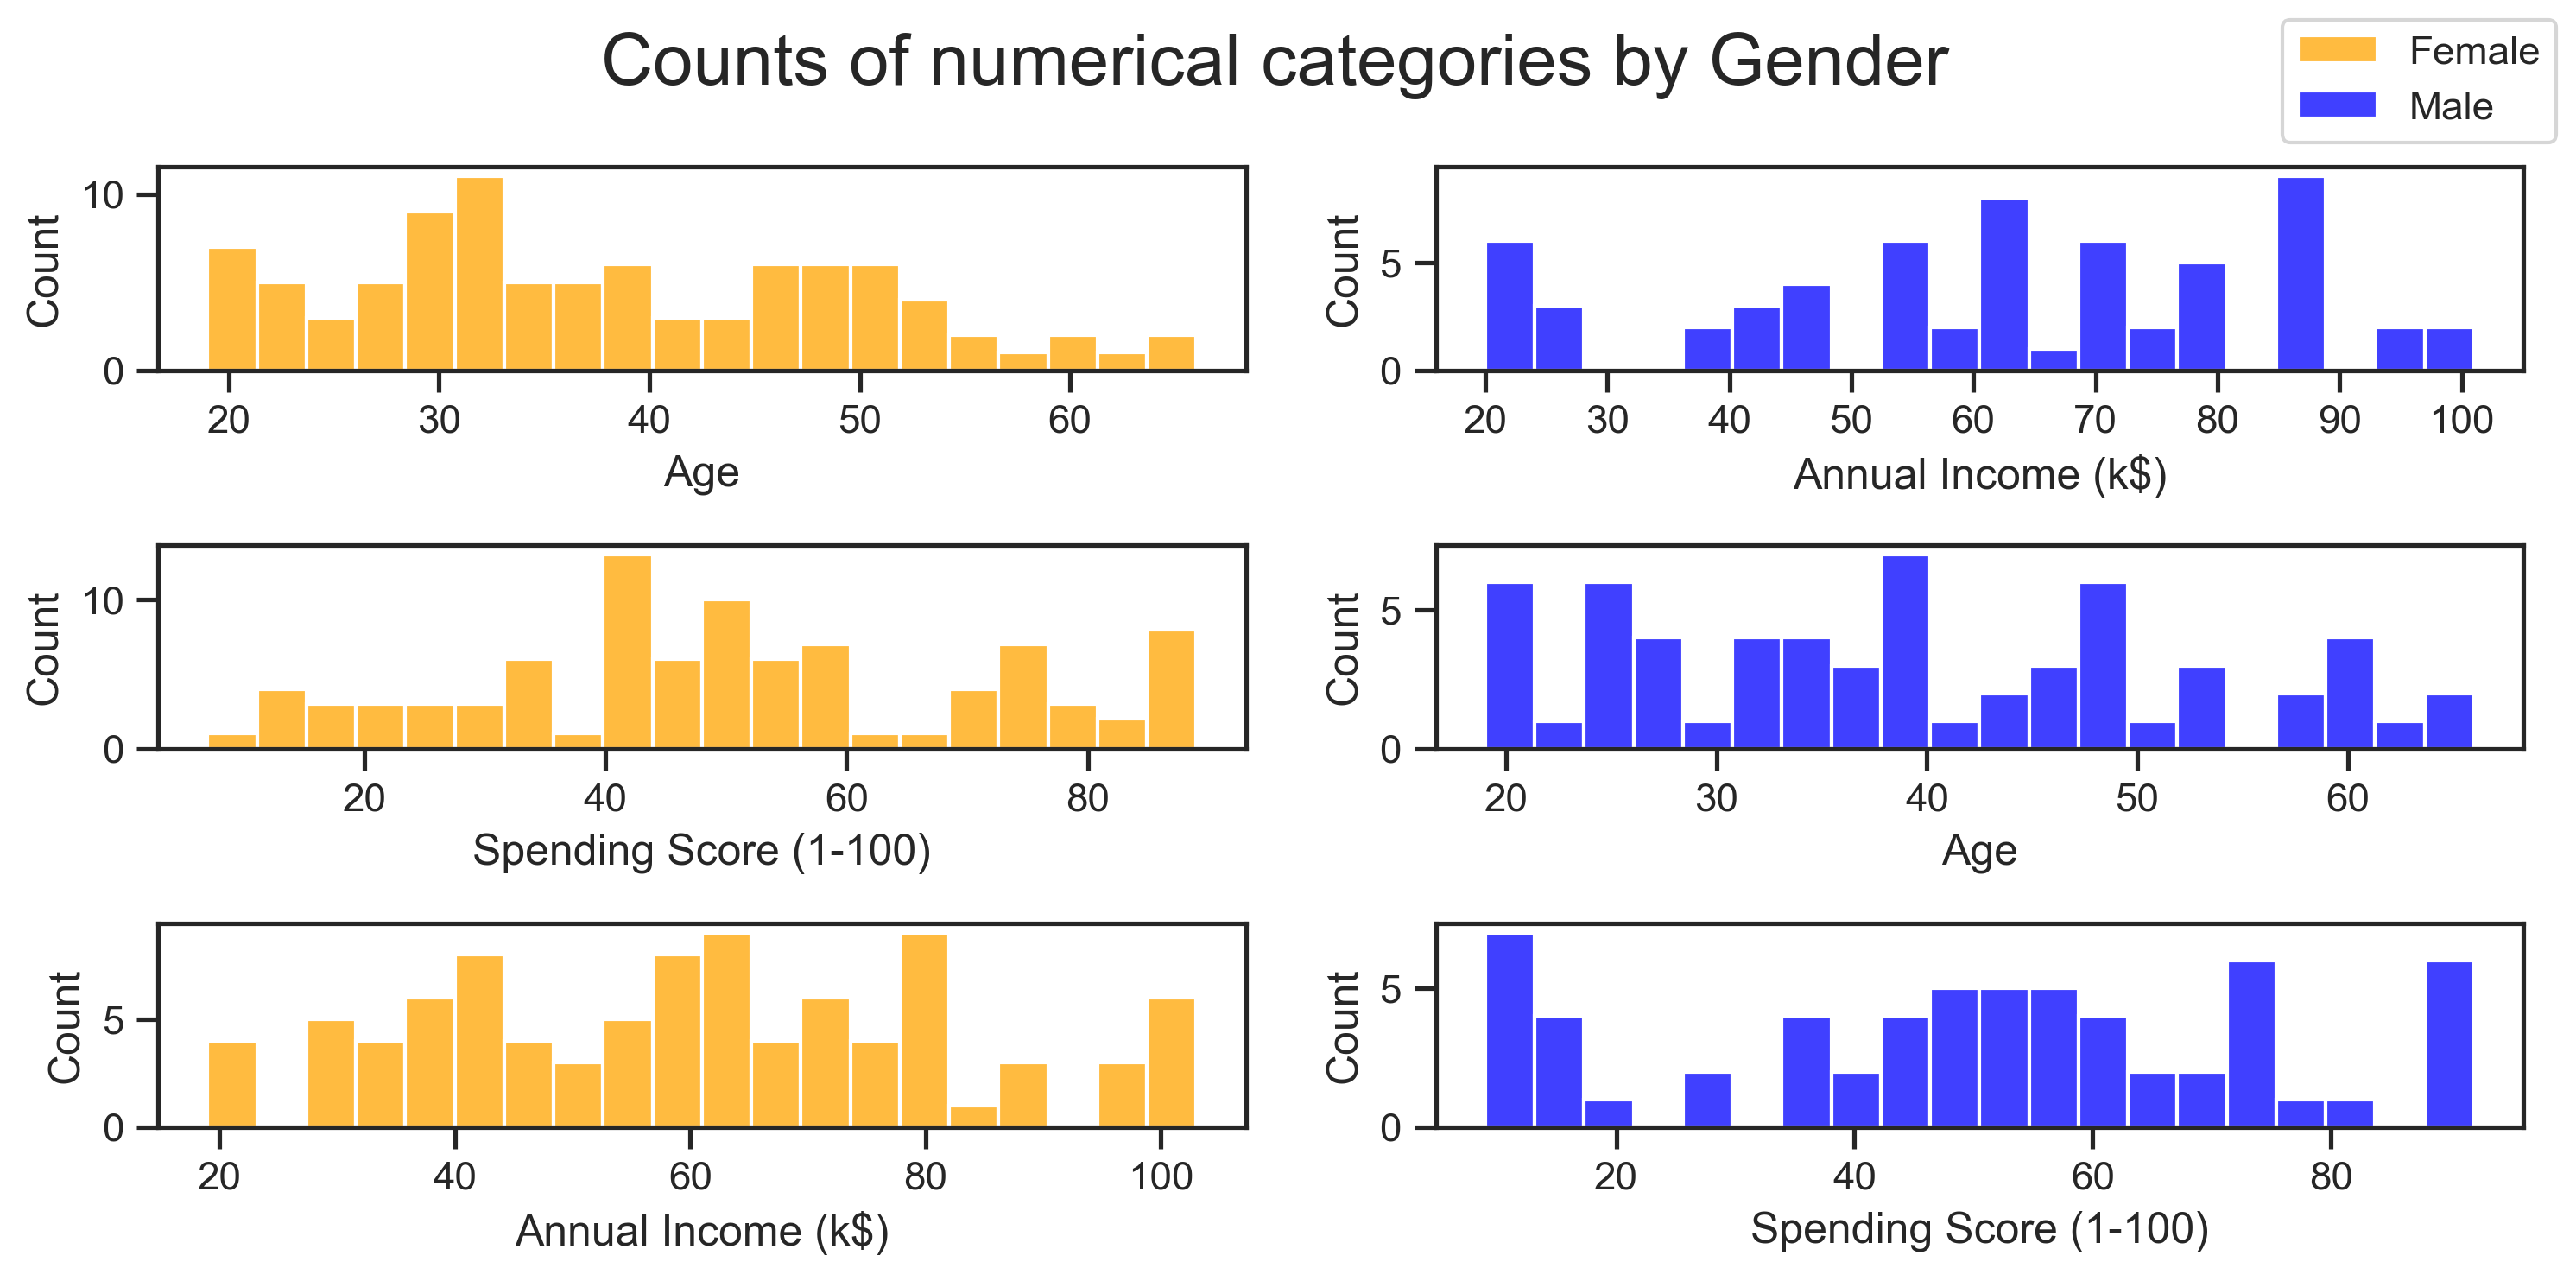

In [61]:
#Countplots
fig = plt.figure(figsize=(10,5), dpi=300)
df_male = df[df['Gender']=='Male']
df_female = df[df['Gender']=='Female']
for i,col in enumerate(numerical_columns*2):
    if (i+1)%2==0:
        plt.subplot(3, 2, i+1)
        sns.histplot(data=df_male, x=col, bins=20, color='blue')
    else:
        plt.subplot(3, 2, i+1)
        sns.histplot(data=df_female, x=col, bins=20, color='orange')
plt.savefig('images/01_Countplots_Gender.png', bbox_inches='tight')
plt.suptitle('Counts of numerical categories by Gender', fontsize=20)
plt.tight_layout()
fig.legend(labels=['Female','Male'])
plt.show()

## Statistical tests

When looking at the box-plots above, one is uncertain as to whether the differences in the median lines for Age, Annual Income and Spending Score bear any actual statistical significance. To find out, we will employ an ANOVA hypothesis test with a confidence level of 95%.